# Thien Nguyen Module 2 Project
Instructor: Eli Thomas

Self-Paced Data Science Course

## Introduction

The purpose of this investigation will be to investigate and extrapolate data from the Northwind data using SQL queries and statistical tests. One primary question will be the focus of each section for a total of four section. Each section will iterate through similar steps:

1. Query required data via SQLite3 & perform the necessary -join's and integrating the data into a pandas dataframe
2. Scrub the dataframe's missing values
3. Establish null and alternative hypothesis 
4. Conduct statistical test(s) to determine significance & effect size.
5. Summarize findings and readdress original inquiry

An overall summary of the entire investigation will be provided at the end.

## Q1 - Do discounts have an effect on the number of products customers order? If so, at what level of discounts?

### 1a. Query Data from Northwind Database & Perform Join's

In [3]:
# Import necessary packages
import sqlite3
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
from datetime import datetime
import scipy.stats as st

In [4]:


#Link to Norwthind Database & Create an engine 
engine = create_engine('sqlite:///Northwind_small.sqlite')
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

#Make sure that the table names match
inspector = inspect(engine)
print(inspector.get_table_names())

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


The column names are slightly different than what is listed in the schema, so accounting for this is crucial henceforth. Let's examine the two tables that hold data pertinent to answering our inquiry-- OrderDetail and Product.

In [5]:
#Query with pandas since it includes the column names, which is super convenient

df = pd.read_sql_query("SELECT * FROM OrderDetail", engine)
df.head()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [6]:
df.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

The discounts range from **0% to 25%**. For the table, the column of interest may be **quantity**, which could indicate the quantity of the order. In addition, the subsequent join will using the ProductId.

In [7]:
df = pd.read_sql_query("SELECT * FROM Product", engine)
df.head()

,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


However, the column of interest could also be the UnitsOnOrder, which *could* point to how many units are currently being ordered. The issue here is that unit does not necessarily translate to number of products nicely, as the "unit amount" for each item varies significantly. Furthermore, there is still ambiguity on what *on order* really means. The quantity column from the order details table is most likely the target variable, but we can also include and conduct A/B tests on UnitsOnOrder too.


In [8]:
#Join both tables on productId and drop all discontinued products. The product name is also included.
df = pd.read_sql_query('''SELECT o.ProductId, o.Discount, o.Quantity, p.ProductName, p.UnitsOnOrder FROM [OrderDetail] o
                       INNER JOIN [Product] p ON o.ProductId = p.Id
                       WHERE (Discontinued ==0)
                       ORDER BY Discount DESC
                       ''', engine)     

df = df.set_index('ProductName')
df.head()


,ProductId,Discount,Quantity,UnitsOnOrder
ProductName,,,,
Jack's New England Clam Chowder,41,0.25,16,0
Tarte au sucre,62,0.25,15,0
Outback Lager,70,0.25,21,10
Pavlova,16,0.25,60,0
Nord-Ost Matjeshering,30,0.25,60,0


In [9]:
#Let's drop the id column since it is an int number type, which may throw off the calculations. 
df.drop('ProductId', axis =1, inplace = True)

In [10]:
df.head()

,Discount,Quantity,UnitsOnOrder
ProductName,,,
Jack's New England Clam Chowder,0.25,16,0
Tarte au sucre,0.25,15,0
Outback Lager,0.25,21,10
Pavlova,0.25,60,0
Nord-Ost Matjeshering,0.25,60,0


### 1b.Scrub Data

In [11]:
df.describe()

,Discount,Quantity,UnitsOnOrder
count,1927.000000,1927.000000,1927.000000
mean,0.056300,23.879606,9.029580
std,0.083328,18.910074,20.677584
min,0.000000,1.000000,0.000000
25%,0.000000,10.000000,0.000000
50%,0.000000,20.000000,0.000000
75%,0.100000,30.000000,0.000000
max,0.250000,130.000000,100.000000


In [12]:
df.isna().sum()

Discount        0
Quantity        0
UnitsOnOrder    0
dtype: int64

While no column has any null values, the UnitsOnOrder column contains mostly 0 with a rather large standard deviation. This may complicate statistic test later on.

### 1c. Establishing Null & Alternative Hypotheses

**Null hypothesis ($H_0$ )**: discounts have no effect in increasing or decreasing the amount of products customers order, regardless of level.

**Alternative hypothesis $H_A$ **: discounts have a statistically significant effect in increasing or decreasing the amount of proudcts customers order.

Although discounts are often thought of as incentives to increase customers' purchases, consumer spending habits are often more psychologically complex. A heavily discounted item might actually have a negative correlation with purchases, as it might indicated undesirability. Therefore, a two-tailed test is appropriate in order to not missing this effect.

### 1d. Conducting Statistical Tests

In [13]:
df.Discount.unique()

array([0.25, 0.2 , 0.15, 0.1 , 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0.  ])

There are 10 levels of discount. A sample test can be performed for each level versus the control group-no discount.

In [14]:
#The control group lacks any discount
control = df[df['Discount'] == 0]

#Create a list of all unique level of discount
exp_list = list(df.Discount.unique())
exp_list = exp_list[0:len(exp_list)-1]
exp_list


[0.25, 0.2, 0.15, 0.1, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]

In [15]:
#Since there are so many levels of discounts, let's see how many items are in each discount category
for level in exp_list:
    print(level, len(df[df['Discount']== level]))

0.25 134
0.2 147
0.15 146
0.1 152
0.06 1
0.05 165
0.04 1
0.03 3
0.02 2
0.01 1


There is an issue because there are almost no items with .01, .02, .03, .04, and .06 discount levels. Conducting a T-test on these groups is impossible because there aren't enough samples to justify any statistical difference. Therefore, it would be best to drop these categories and focus on the bulk of the data.

In [16]:
drop_discount = list(df.loc[(df.Discount ==.06) | (df.Discount<=.04) & (df.Discount!=0)].index)
drop_discount

['Camembert Pierrot',
 "Sir Rodney's Marmalade",
 'Tofu',
 'Pavlova',
 'Wimmers gute Semmelknödel',
 "Grandma's Boysenberry Spread",
 'Spegesild',
 'Röd Kaviar']

In [17]:
#drop the the columns
df = df.drop(drop_discount)

#check to see if they've been dropped
for level in exp_list:
    print(level, len(df[df['Discount']== level]))

0.25 118
0.2 136
0.15 126
0.1 134
0.06 0
0.05 143
0.04 0
0.03 0
0.02 0
0.01 0


Perfect! With this, there are only 5 discount categories, and they are all multiples of 5%, which is a much nicer and more even distribution of discount levels

In [18]:
#Use a loop to run a two-sample t-test through both possible target variables and append it to a list. 
exp_list = [.25, .20, .15, .10, .05]

t_test_results = []

for var in ['Quantity', 'UnitsOnOrder']:
    for discount_level in exp_list:
        result = stats.ttest_ind(df[df['Discount']==discount_level][var], control[var])
        t_test_results.append([discount_level,result])
        print('P-value at discount level {} for {} is {}'.format(discount_level, var ,result[1]))
        

P-value at discount level 0.25 for Quantity is 0.0010229921002012031
P-value at discount level 0.2 for Quantity is 0.000797274302843069
P-value at discount level 0.15 for Quantity is 3.826058587651554e-06
P-value at discount level 0.1 for Quantity is 0.1407459208822454
P-value at discount level 0.05 for Quantity is 0.0003421319140783394
P-value at discount level 0.25 for UnitsOnOrder is 0.38399890425721617
P-value at discount level 0.2 for UnitsOnOrder is 0.2706857290017817
P-value at discount level 0.15 for UnitsOnOrder is 0.2801915651540492
P-value at discount level 0.1 for UnitsOnOrder is 0.16123740871354705
P-value at discount level 0.05 for UnitsOnOrder is 0.711242285497282


At this point it is pretty obvious that the p-values for UnitsOnOrder are **not** statistically significant at all, so it would be safe to drop this column within the dataframe, since it would no longer be relevant to answering the proposed question. Further, this is not really surprising given the distribution of data seen when running the describe method on UnitsOnOrder (Ie. most of the data in the column was 0). 

In [19]:
df.drop('UnitsOnOrder', axis = 1, inplace =True)
df.head()

,Discount,Quantity
ProductName,,
Jack's New England Clam Chowder,0.25,16
Tarte au sucre,0.25,15
Outback Lager,0.25,21
Nord-Ost Matjeshering,0.25,60
Longlife Tofu,0.25,36


In [20]:
#Since UnitsOnOrder is no longer relevant, we can also chop off its t_test results as well. 
t_test_results = t_test_results[0:5]
t_test_results

[[0.25,
  Ttest_indResult(statistic=3.2916366317769845, pvalue=0.0010229921002012031)],
 [0.2,
  Ttest_indResult(statistic=3.361600747239699, pvalue=0.000797274302843069)],
 [0.15,
  Ttest_indResult(statistic=4.640564256745567, pvalue=3.826058587651554e-06)],
 [0.1,
  Ttest_indResult(statistic=1.473912624924472, pvalue=0.1407459208822454)],
 [0.05,
  Ttest_indResult(statistic=3.5905413124769194, pvalue=0.0003421319140783394)]]

The only discount level where the null hypothesis cannot be rejected with 95% confidence is at .1, which is presumably a ten percent discount.

In [21]:
#visualizes t-statistic on a normal distribution
def visualize_t(t_stat, n_control, n_exp):
    fig = plt.figure(figsize =(8,5))
    ax = fig.gca()
    
    xs = np.linspace(-4,4,500)
    
    ys = stats.t.pdf(xs, (n_control-n_exp-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color = 'red')
    
    ax.axvline(t_stat, color = 'black')
    ax.axvline(-t_stat, color = 'black')
    
    plt.show()


Discount Level: 0.25


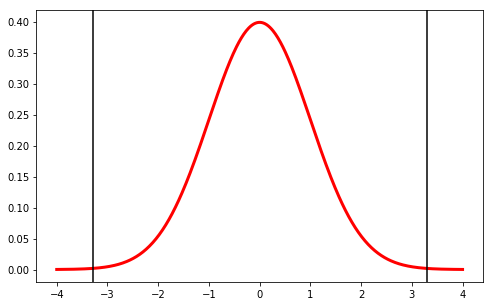

Discount Level: 0.2


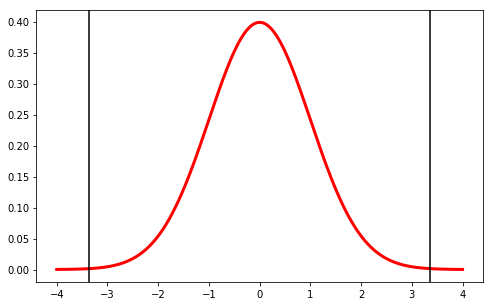

Discount Level: 0.15


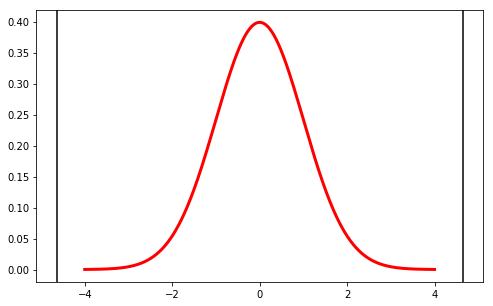

Discount Level: 0.1


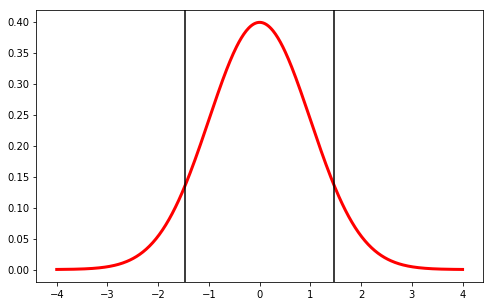

Discount Level: 0.05


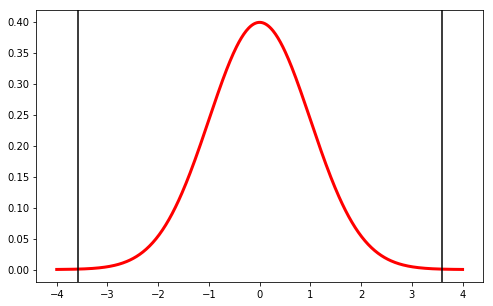

In [22]:
for t_test in t_test_results:
    n_control = len(control)
    n_exp = len(df[df['Discount']== t_test[0]])
    t_stat = (t_test[1])[0]
    print('Discount Level:', t_test[0])
    visualize_t(t_stat, n_control, n_exp)

### Post-Test Analysis
Other than ten percent, every level of discount seems to have a statistically significant impact on the quantity of items customers order. This is somewhat surprising since conventional wisdom would suggest a correlation between items sold and discount level. To see if this finding still holds true, a Kolmogorov–Smirnov test can also be conducted on the data

In [23]:
#Use a loop to run a two-sample KS test through predictor (discount) and target variable (quantity) and append it to a list. 

exp_list = [.25, .20, .15, .10, .05]

ks_test_results = []

#UnitsonOrder will be omitted this time, since it has already been ruled to be statistically insignifcant.
for var in ['Quantity']:
    for discount_level in exp_list:
        result = stats.ks_2samp(df[df['Discount']==discount_level][var], control[var])
        ks_test_results.append([discount_level,result])
        print('P-value at discount level {} for {} is {}'.format(discount_level, var ,result[1]))
        

P-value at discount level 0.25 for Quantity is 0.004082056647206293
P-value at discount level 0.2 for Quantity is 0.011158875750229509
P-value at discount level 0.15 for Quantity is 0.008071926815490255
P-value at discount level 0.1 for Quantity is 0.9461764192960436
P-value at discount level 0.05 for Quantity is 0.012102604286204204


Again, all levels of discount, **except for .1**, has a statistically significant impact on the quantity of items sold. The KS test concurs with our 2-sample t-test: a discount of ten percent (.1) forces an acceptance of the null hypothesis.  

### Testing Effect with ANOVA 

In [24]:
#ANOVA on the discount level and quantity
formula = 'Quantity ~ Discount'
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq      df          F        PR(>F)
Discount   10069.58711     1.0  28.752179  9.346603e-08
Residual  598876.13018  1710.0        NaN           NaN


In its current form, ANOVA on the dataframe is kind of a moot point, since previous statistical tests have already shown that discounts are statistically significant in general. Therefore, it would be more interesting to see how influential each category of discount is on the overall quantity.

In [25]:
df.head()

,Discount,Quantity
ProductName,,
Jack's New England Clam Chowder,0.25,16
Tarte au sucre,0.25,15
Outback Lager,0.25,21
Nord-Ost Matjeshering,0.25,60
Longlife Tofu,0.25,36


To see how influential each discount level is on the quantity ordered of each item, we can create dummies corrresponding to each discount level and use ANOVA on each category.

In [26]:
#Create dummies for each discount level
df_dum= pd.concat([pd.get_dummies(df['Discount']), df['Quantity']], axis = 1)
df_dum.head()

,0.0,0.05,0.1,0.15,0.2,0.25,Quantity
ProductName,,,,,,,
Jack's New England Clam Chowder,0,0,0,0,0,1,16
Tarte au sucre,0,0,0,0,0,1,15
Outback Lager,0,0,0,0,0,1,21
Nord-Ost Matjeshering,0,0,0,0,0,1,60
Longlife Tofu,0,0,0,0,0,1,36


In [27]:
formula = 'Quantity ~ C(0.0)+ C(0.05)+C(0.1)+C(0.15)+C(0.2)+C(0.25)'
lm = ols(formula, df_dum).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

PatsyError: Number of rows mismatch between data argument and C(0.0) (1712 versus 1)
    Quantity ~ C(0.0)+ C(0.05)+C(0.1)+C(0.15)+C(0.2)+C(0.25)
               ^^^^^^

The Patsy Error seems to think that C(0.0) and etc refers to only one row of data. To mitigate this, the columns can be renamed.

In [28]:
df_dum.columns = ['zero', 'five', 'ten', 'fifteen', 'twenty', 'twenty_five', 'Quantity']
df_dum.head()

,zero,five,ten,fifteen,twenty,twenty_five,Quantity
ProductName,,,,,,,
Jack's New England Clam Chowder,0,0,0,0,0,1,16
Tarte au sucre,0,0,0,0,0,1,15
Outback Lager,0,0,0,0,0,1,21
Nord-Ost Matjeshering,0,0,0,0,0,1,60
Longlife Tofu,0,0,0,0,0,1,36


In [29]:
formula = 'Quantity ~ C(five)+C(ten)+C(fifteen)+C(twenty)+C(twenty_five)'
lm = ols(formula, df_dum).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                       sum_sq      df          F    PR(>F)
C(five)           4438.876327     1.0  12.737527  0.000368
C(ten)             828.216689     1.0   2.376600  0.123351
C(fifteen)        7170.787794     1.0  20.576852  0.000006
C(twenty)         3706.888428     1.0  10.637059  0.001130
C(twenty_five)    3626.052389     1.0  10.405097  0.001280
Residual        594520.669218  1706.0        NaN       NaN


### Table Analysis

The table aligns with our results from the t-test and ks-test, but also gives insight on how much each discount category influences the quantity of items purchased. The most influential discount seems to be fifteen percent followed by five percent with barely any differences between twenty and twenty five percent.

### Q1 Conclusion

From these results, it is clear that **discounts do have a statistically significant effect on the number of products consumers order**. Thus, the **null hypothesis is rejected.** However, as with all statistic testing, *correlation does not imply causation*. The ANOVA analysis reveals that a discount of .15 has the greatest effect on quantity ordered, but it would be hasty and fallacious to assume that to be the best way to sell more products. 

### Further Considerations

To better predict what has more of a direct impact on the number of products consumers order, it is necessary to take into account possible multicollinearity. Perhaps some other attribute(s) of the product better explains both why consumers order more of it along with why it is discounted at a certain level. For example, if there is a correlation between shelf life and discount level, consumers might be more hesitant to buy an older product for a more significant discount than a fresher product for less of a discount, which would explain why a discount of .15 seems to have the biggest effect on quantity ordered. With more time and data, it would be possible to discern if such a relationship (and others) exists. 

## Q2 - Do certain employees do better or worse than others in quantity of items sold in each order? If so, who seems to do the best?


### 2a. Query Data and join OrderDetail, Order, and Employee

In [30]:
df2 = pd.read_sql_query("""SELECT e.LastName, e.FirstName, o.id, od.Quantity
FROM [OrderDetail] od
INNER JOIN [Order] o on o.Id = od.OrderId
INNER JOIN [Employee] e on e.Id = o.EmployeeId
""" ,engine)

df2.head()

,LastName,FirstName,Id,Quantity
0,Buchanan,Steven,10248,12
1,Buchanan,Steven,10248,10
2,Buchanan,Steven,10248,5
3,Suyama,Michael,10249,9
4,Suyama,Michael,10249,40


### 2b. Scrub Data

In [31]:
df2.isna().sum()

LastName     0
FirstName    0
Id           0
Quantity     0
dtype: int64

Doesn't seem to be any NaN values. Let's check to see if any values are filling in for NaN

In [32]:
df2.describe()

,Id,Quantity
count,2155.000000,2155.000000
mean,10659.375870,23.812993
std,241.378032,19.022047
min,10248.000000,1.000000
25%,10451.000000,10.000000
50%,10657.000000,20.000000
75%,10862.500000,30.000000
max,11077.000000,130.000000


The Id column is treated as an int, so perhaps conversion to categorical data is needed. However, we can simply use the employee's name as our categorical column. Other than that, there doesn't seem to be any extreme values for quantity.

In [33]:
#For readability, a full name column can be used. 
df2['FullName'] = df2['FirstName'] + ' ' +df2['LastName']
df2.head()

,LastName,FirstName,Id,Quantity,FullName
0,Buchanan,Steven,10248,12,Steven Buchanan
1,Buchanan,Steven,10248,10,Steven Buchanan
2,Buchanan,Steven,10248,5,Steven Buchanan
3,Suyama,Michael,10249,9,Michael Suyama
4,Suyama,Michael,10249,40,Michael Suyama


### 2c. Establishing Null & Alternative Hypotheses

Unlike question #1, it is difficult to determine what should be the control group. After all, *any* employee will have an impact on the amount of items sold when compared to zero employees. In answering the question #2, null and alternative hypothesis can be reframed around any single employee as a control variable. After all, if employee A sells a different amount of product than employees B, C, and etc., then the primary question posed in this section will be answered--specific employees vary in their performance. 

**Null hypothesis ($H_0$ )**: Employee A performs equally the same in quantity of items sold as all other employees.

**Alternative hypothesis $H_A$** : Employee A performs better or worse in quantity of items sold compared to all other empoloyees.

A **two-tailed test** is appropriate since we are considering that Employee A may perform better or worse.

### 2d. Conduct Statistical Tests

In [34]:
df2.FullName.unique()

array(['Steven Buchanan', 'Michael Suyama', 'Margaret Peacock',
       'Janet Leverling', 'Anne Dodsworth', 'Nancy Davolio',
       'Laura Callahan', 'Andrew Fuller', 'Robert King'], dtype=object)

In [35]:
df2.head()

,LastName,FirstName,Id,Quantity,FullName
0,Buchanan,Steven,10248,12,Steven Buchanan
1,Buchanan,Steven,10248,10,Steven Buchanan
2,Buchanan,Steven,10248,5,Steven Buchanan
3,Suyama,Michael,10249,9,Michael Suyama
4,Suyama,Michael,10249,40,Michael Suyama


In [36]:
#For the control, we can select any employee arbitrarily. In this case, it will be Margaret Peacock
control2 = df2[df2['LastName'] == 'Peacock']


In [37]:
#List of employees by last name
emp_list = list(df2.LastName.unique())

#store results here
t_test_results = []

#runs two-sample t-test on every employee with Ms. Peacock
for employee in emp_list:
    result = stats.ttest_ind(df2[df2['LastName']==employee]['Quantity'], control2['Quantity'])
    t_test_results.append([employee,result])
    print('P-value for employee {} for {} is {}. The t-statistic is {}'.format(employee, var ,result[1], result[0]))
        

P-value for employee Buchanan for Quantity is 0.18098596469244474. The t-statistic is 1.3394714684959677
P-value for employee Suyama for Quantity is 0.14938330192584232. The t-statistic is -1.4436092211715257
P-value for employee Peacock for Quantity is 1.0. The t-statistic is 0.0
P-value for employee Leverling for Quantity is 0.40238909759235353. The t-statistic is 0.8378442050835527
P-value for employee Dodsworth for Quantity is 0.4072886690148467. The t-statistic is 0.8293405073588414
P-value for employee Davolio for Quantity is 0.6165470921269637. The t-statistic is -0.5009552603396032
P-value for employee Callahan for Quantity is 0.6777180891307932. The t-statistic is -0.4157587670902297
P-value for employee Fuller for Quantity is 0.24935266755867483. The t-statistic is 1.1529408903107266
P-value for employee King for Quantity is 0.06934971376089094. The t-statistic is 1.8194261140084604


The results reveal two things. First, the t-statistic indicates how much better or worse the individual in question does in sales compared to Ms. Peacock- the control variable. Second, the p-value corresponds with the confidence in which the two samples are statistically different, since 1-p equals confidence. For example, the t-statistic for King suggests he performs better in sales than Ms. Peacock with a confidence level of about 93%. This is a little less the usual accepted value of 95%, but can still provide a clear image of Ms. Peacock's general performance compared to her peers. However, the null hypothesis cannot be rejected with Ms. Peacock as the control.

### Repeat T-Test with Suyama

According to the t-score, Suyama seems to do perceivably worse than his peers. Perhaps repeating a t-test with Suyama as the control will allow for a rejection of the null hypothesis.

In [38]:
#sets control group to Suyama
control2= df2[df2['LastName'] == 'Suyama']

t_test_results = []

#runs two-sample t-test on every employee with Suyama
for employee in emp_list:
    result = stats.ttest_ind(df2[df2['LastName']==employee]['Quantity'], control2['Quantity'])
    t_test_results.append([employee,result])
    print('P-value for employee {} for {} is {}. The t-statistic is {}'.format(employee, var ,result[1], result[0]))

P-value for employee Buchanan for Quantity is 0.02666223080052856. The t-statistic is 2.2280627673097073
P-value for employee Suyama for Quantity is 1.0. The t-statistic is 0.0
P-value for employee Peacock for Quantity is 0.14938330192584232. The t-statistic is 1.4436092211715257
P-value for employee Leverling for Quantity is 0.0417044738709792. The t-statistic is 2.0418519367466623
P-value for employee Dodsworth for Quantity is 0.06420736715610872. The t-statistic is 1.8582673747348462
P-value for employee Davolio for Quantity is 0.3499801180018812. The t-statistic is 0.9354853112244217
P-value for employee Callahan for Quantity is 0.3044303487476871. The t-statistic is 1.0282188415602604
P-value for employee Fuller for Quantity is 0.035263198719247525. The t-statistic is 2.112371016157483
P-value for employee King for Quantity is 0.008630450259072192. The t-statistic is 2.6416009886003975


With Suyama as the control, the **the null hypothesis is rejected** since Buchanan, Leverling, Fuller, and King all perform significantly better than Suyama. This also answers question #2, since it is clear that certain employees do perform better than other. The data suggests that King performs the best, but for testing the effect of multiple groups (employees) at once, ANOVA would be the best approach. 

### Testing with ANOVA

However, the important question is how each person performs individually without direct comparison to any specific employee. This requires using ANOVA, as the test allows for testing the effects of three or more groups. Specifically, a type 2 ANOVA will be conducted, since no interaction between employees will be assumed. This may arguably not be true in real life, but it would be a good assumption that no employee's success or failure interfered with the others'.

In [39]:
#Since each employee is essentially a category, dummies will be created for each
df2_dum= pd.concat([pd.get_dummies(df2['LastName']), df2['Quantity']], axis = 1)

df2_dum.head()

,Buchanan,Callahan,Davolio,Dodsworth,Fuller,King,Leverling,Peacock,Suyama,Quantity
0,1,0,0,0,0,0,0,0,0,12
1,1,0,0,0,0,0,0,0,0,10
2,1,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,1,9
4,0,0,0,0,0,0,0,0,1,40


In [40]:
#For a for-loop through the names list to create the formula
formula = 'Quantity ~ C(Buchanan)'
for name in list(df2.LastName.unique()[1:]):
    formula += '+ C({})'.format(name)
    
#Run formula through ANOVA
formula
lm = ols(formula, df2_dum).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq      df          F    PR(>F)
C(Buchanan)     2516.118829     1.0   6.969404  0.008352
C(Suyama)         85.943519     1.0   0.238055  0.625664
C(Peacock)      1172.237111     1.0   3.246983  0.071695
C(Leverling)    2650.970597     1.0   7.342931  0.006786
C(Dodsworth)    1363.425693     1.0   3.776557  0.052106
C(Davolio)       345.408958     1.0   0.956749  0.328118
C(Callahan)      328.876262     1.0   0.910955  0.339969
C(Fuller)       3169.243807     1.0   8.778497  0.003082
C(King)         4564.060611     1.0  12.642004  0.000385
Residual      774756.452913  2146.0        NaN       NaN


### Q2 Conclusion

The results concur with the previous t-tests about who performs relatively worse and better than Ms. Peacock. However, the p-value here allows a more direct interpretation about the effects of each employee. 
- In terms of statistical significance, Buchanan, Leverling, Fuller, and King (and almost Dodsworth) all had a significant impact on the quantity of items sold. 
- King seemed to have the biggest effect followed by Fuller, Leverling and Buchanan.
- Suyama, Davolio, and Callahan have a statistically insignificant impact on the quantity sold.
- Ms. Peacock and Mr. Dodsworth came close to the threshold of being statistically significant.

### Q2 Further Considerations

Each employee's access to clients is also a pretty important consideration. It may be that King sells more product than Suyama, but that may not be impressive if King's territories are all metropolitan areas while Suyama works in rural areas. Furthermore, the sheer quantity of product does not reflect the overall net revenue brought in by each employee. Having, for example, item cost and item sales price, would allow for a more fair comparison of how much money each employee generates.

## Q3 - Do consumers buy certain categories of items more than other? If so, which categories?


### 3a. Query Data
Join OrderDetail, Product, and Category table to select category names and respective quantites from each category.

In [41]:
df3 = pd.read_sql_query('''SELECT c.CategoryName, c.Description, od.Quantity, c.Id FROM [OrderDetail] od
JOIN [Product] p on od.ProductId = p.Id 
JOIN [Category] c on p.CategoryId = c.Id
ORDER BY c.Id''',engine)

df3.head()

,CategoryName,Description,Quantity,Id
0,Beverages,"Soft drinks, coffees, teas, beers, and ales",42,1
1,Beverages,"Soft drinks, coffees, teas, beers, and ales",15,1
2,Beverages,"Soft drinks, coffees, teas, beers, and ales",20,1
3,Beverages,"Soft drinks, coffees, teas, beers, and ales",6,1
4,Beverages,"Soft drinks, coffees, teas, beers, and ales",50,1


### 3b. Scrub Data

In [42]:
df3.isna().sum()

CategoryName    0
Description     0
Quantity        0
Id              0
dtype: int64

No null values found. In addition, Id seems to be a moot point, so it will not be considered in future statistical tests.

### 3c. Establishing Null and Alternative Hypothesis

Like question #2, the control group will have to be arbitrarily chosen. In this case, it will be beverage starting off. However, the control group can simply be changed and tests can be repeated as done in #2 to detect any significant differences between item categories.

**Null hypothesis ($H_0$ )**: The control group performs equally the same in quantity of items sold as all other categories.

**Alternative hypothesis $H_A$** : Employee A performs better or worse in quantity of items sold compared to all other categories.

A **two-tailed test** is appropriate since we are considering that the control may perform better or worse.

### 3d. Statistical Testing

In [56]:
df3.CategoryName.unique()

array(['Beverages', 'Condiments', 'Confections', 'Dairy Products',
       'Grains/Cereals', 'Meat/Poultry', 'Produce', 'Seafood'],
      dtype=object)

### T-Test

In [45]:
#sets control to beverages
control3 = df3[df3['CategoryName'] == 'Beverages']

t_test_results = []

cat_list = list(df3.CategoryName.unique())

#runs two-sample t-test on every category against Beverages
for category in cat_list:
    result = stats.ttest_ind(df3[df3['CategoryName']==category]['Quantity'], control3['Quantity'])
    t_test_results.append([category,result])
    print('P-value for employee {} for {} is {}. The t-statistic is {}'.format(category, var ,result[1], result[0]))

P-value for employee Beverages for Quantity is 1.0. The t-statistic is 0.0
P-value for employee Condiments for Quantity is 0.5684473441892319. The t-statistic is 0.5706455693695196
P-value for employee Confections for Quantity is 0.9550338599469655. The t-statistic is 0.056405781688004517
P-value for employee Dairy Products for Quantity is 0.30699035235174804. The t-statistic is 1.022237583707937
P-value for employee Grains/Cereals for Quantity is 0.8466353989800597. The t-statistic is -0.1934970772917259
P-value for employee Meat/Poultry for Quantity is 0.7117398551247558. The t-statistic is 0.36970308050720474
P-value for employee Produce for Quantity is 0.39447034231166644. The t-statistic is -0.8522215496277242
P-value for employee Seafood for Quantity is 0.8232238155068803. The t-statistic is -0.22348062200554564


With *beverages* as the control, the **null hypothesis is accepted** for grouping of food categories. However, the t-score shown by produce suggest it sells the lowest compared to other categories, so perhaps there may be a significant result if it becomes the control group

### T-Test with Produce as Control

In [46]:
#sets control to Produce
control3 = df3[df3['CategoryName'] == 'Produce']

t_test_results = []

cat_list = list(df3.CategoryName.unique())

#runs two-sample t-test on every category against Produce
for category in cat_list:
    result = stats.ttest_ind(df3[df3['CategoryName']==category]['Quantity'], control3['Quantity'])
    t_test_results.append([category,result])
    print('P-value for employee {} for {} is {}. The t-statistic is {}'.format(category, var ,result[1], result[0]))

P-value for employee Beverages for Quantity is 0.39447034231166644. The t-statistic is 0.8522215496277242
P-value for employee Condiments for Quantity is 0.22916528861243896. The t-statistic is 1.204616557575513
P-value for employee Confections for Quantity is 0.3477180633522532. The t-statistic is 0.9399695613495002
P-value for employee Dairy Products for Quantity is 0.10966251588018955. The t-statistic is 1.6025637449772276
P-value for employee Grains/Cereals for Quantity is 0.5291367739990306. The t-statistic is 0.629990478016996
P-value for employee Meat/Poultry for Quantity is 0.33530032056189885. The t-statistic is 0.965008036788394
P-value for employee Produce for Quantity is 1.0. The t-statistic is 0.0
P-value for employee Seafood for Quantity is 0.5047002759339202. The t-statistic is 0.6676322576392099


Testing between produce and Dairy products almost produce a significant difference, but it still falls short of the accepted .05 alpha level. Therefore, the **null hypothesis is still accepted**, and reject the notion that, between any two items, consumers may necessarily prefer one over the other. 

However, the limitation of t-testing is the singular focus on only two groups. For anything more, ANOVA must be used

### Testing with ANOVA

In [47]:
#Since each item category is essentially a category type, dummies will be created for each
df3_dum= pd.concat([pd.get_dummies(df3['CategoryName']), df3['Quantity']], axis = 1)

df3_dum.head()

,Beverages,Condiments,Confections,Dairy Products,Grains/Cereals,Meat/Poultry,Produce,Seafood,Quantity
0,1,0,0,0,0,0,0,0,42
1,1,0,0,0,0,0,0,0,15
2,1,0,0,0,0,0,0,0,20
3,1,0,0,0,0,0,0,0,6
4,1,0,0,0,0,0,0,0,50


In [48]:
#For a for-loop through the names list to create the formula
formula = 'Quantity ~ C(Beverages)'
for name in list(df3.CategoryName.unique()[1:]):
    formula += '+ C({})'.format(name)
    
#Run formula through ANOVA
formula
lm = ols(formula, df3_dum).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

SyntaxError: invalid syntax (<unknown>, line 1)

Seems to be a syntax error arising from some of the column titles

In [55]:
new_columns = ['Beverages', 'Condiments', 'Confections', 'Dairy_Products', 'Grains_Cereals', 'Meat_Poultry', 'Produce', 'Seafood', 'Quantity']

#For a for-loop through the names list to create the formula
formula = 'Quantity ~ C(Beverages)'
for name in list(new_columns[1:-1]): #excludes quantity
    formula += '+ C({})'.format(name)

#Rename columns to avoid error
df3_dum.columns = new_columns

#Run formula through ANOVA
formula
lm = ols(formula, df3_dum).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq      df          F    PR(>F)
C(Beverages)         2723.126433     1.0   7.513813  0.006173
C(Condiments)        2978.993057     1.0   8.219815  0.004184
C(Confections)       2466.494182     1.0   6.805698  0.009150
C(Dairy_Products)    6068.824554     1.0  16.745463  0.000044
C(Grains_Cereals)    1111.812816     1.0   3.067780  0.080001
C(Meat_Poultry)      2089.482268     1.0   5.765424  0.016429
C(Produce)            137.507791     1.0   0.379420  0.537979
C(Seafood)           1757.137198     1.0   4.848398  0.027778
Residual           778107.259110  2147.0        NaN       NaN


### Q3 Conclusions
Since ANOVA allows us to see the effects of all types of categories, the results are somewhat contrary to those obtained by the t-test. **Beverages, Condiments, Dairy Products, Meat, and Seafood** all seem to have a significant impact on the quantity of items purchased. Yet, a type II ANOVA assumes no interaction between groups, which is most likely not the case here (e.g. people often buy condiments along with meats). Therefore, the ANOVA results should be taken with a grain of salt. 

### Further Considerations

As a whole, there may not be a significant difference, but dividing orders up using a time series might allow us to see when certain categories of items sell more or less than others. This would allow for better control of the supply-chain and pricing. 

## Q4 - Does shipping company affect the downtime between order and shipment? If so, which shipping companies ship the fastest?


### 4a. Query Data and Join Table from Order and Shipper

In [57]:
df = pd.read_sql_query('''SELECT * from [Order]''', engine)
df.head(6)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium
5,10253,HANAR,3,2012-07-10,2012-07-24,2012-07-16,2,58.17,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil


In [58]:
df = pd.read_sql_query('''SELECT * from [Shipper]''', engine)
df

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


The key for the join will be the Shipper Id and the ShipVia column under the order table

In [59]:
#Query data and join both the order and shipper table 
df4 = pd.read_sql_query('''SELECT s.CompanyName, o.OrderDate, o.ShippedDate, o.id
FROM [Order] o
JOIN [Shipper] s
ON o.ShipVia = s.Id
''', engine)

df4.head()

,CompanyName,OrderDate,ShippedDate,Id
0,Federal Shipping,2012-07-04,2012-07-16,10248
1,Speedy Express,2012-07-05,2012-07-10,10249
2,United Package,2012-07-08,2012-07-12,10250
3,Speedy Express,2012-07-08,2012-07-15,10251
4,United Package,2012-07-09,2012-07-11,10252


In [60]:
type(df4['OrderDate'][0])

str

The OrderDate and ShippedDate column of the dataframe is string, so conversion to datetime is necessary.

In [61]:
#Convert str to datetime
df4.OrderDate = pd.to_datetime(df4.OrderDate)
df4.ShippedDate = pd.to_datetime(df4.ShippedDate)

In [62]:
type(df4['OrderDate'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [63]:
#The Ship Time would just be difference between when the order was placed and how long it took to ship it
df4['ShipTime'] = df4['ShippedDate'] - df4['OrderDate']
df4.head()

,CompanyName,OrderDate,ShippedDate,Id,ShipTime
0,Federal Shipping,2012-07-04,2012-07-16,10248,12 days
1,Speedy Express,2012-07-05,2012-07-10,10249,5 days
2,United Package,2012-07-08,2012-07-12,10250,4 days
3,Speedy Express,2012-07-08,2012-07-15,10251,7 days
4,United Package,2012-07-09,2012-07-11,10252,2 days


In [64]:
#Since ShipTime is a datetime, let's convert it to an int for easy statistical analysis
df4['ShipTimeInt'] = df4['ShipTime'].dt.days
df4.head()

,CompanyName,OrderDate,ShippedDate,Id,ShipTime,ShipTimeInt
0,Federal Shipping,2012-07-04,2012-07-16,10248,12 days,12.0
1,Speedy Express,2012-07-05,2012-07-10,10249,5 days,5.0
2,United Package,2012-07-08,2012-07-12,10250,4 days,4.0
3,Speedy Express,2012-07-08,2012-07-15,10251,7 days,7.0
4,United Package,2012-07-09,2012-07-11,10252,2 days,2.0


### 4b Scrub Data 

In [65]:
df4.isna().sum()

CompanyName     0
OrderDate       0
ShippedDate    21
Id              0
ShipTime       21
ShipTimeInt    21
dtype: int64

In [66]:
len(df4)

830

For 21 entries, the shipped date is null, which may indicate that it has not been shipped yet. Since this is a relatively small amount of entries compared to the 830 entries in the dataframe, it should be fine to drop.

In [67]:
#Check NaN have been dropped
df4 = df4.drop(df4[df4['ShippedDate'].isna()].index)
df4.isna().sum()

CompanyName    0
OrderDate      0
ShippedDate    0
Id             0
ShipTime       0
ShipTimeInt    0
dtype: int64

### 4c. Establishing Null and Alternate Hypothesis

Similar to question #2, establishing the control variable here requires an arbitrary decision about which shipper to use for comparison. This is obvious because without any shippers, the quantity of items sold would almost certainly be 0. Therefore, the null and alternative hypothesis adopt a similar structure as #2. 

**Null Hypothesis**: Shipper A's time discrepancy between the Order Date and the Shipped Date are the same as all other shippers. 

**Alternative Hypothesis**: Shipper A's time discrepancy between the Order and Shipped Date is different than all other shippers.

This will also be a **two-tailed test** to see if Shipper A is slower (lower tail) or faster (upper tail) than other shippers

In [68]:
df4['CompanyName'].unique()

array(['Federal Shipping', 'Speedy Express', 'United Package'],
      dtype=object)

### 4d. Statistical Testing

In [69]:
control4 = df4[df4['CompanyName'] == 'Federal Shipping']


comp_list = list(df4.CompanyName.unique())


t_test_results = []

for company in comp_list:
    result = stats.ttest_ind(df4[df4['CompanyName']==company]['ShipTimeInt'], control4['ShipTimeInt'])
    t_test_results.append([company,result])
    print('P-value for employee {} for {} is {}. The t-statistic is {}'.format(company, var ,result[1], result[0]))
        

P-value for employee Federal Shipping for Quantity is 1.0. The t-statistic is 0.0
P-value for employee Speedy Express for Quantity is 0.051518480756652135. The t-statistic is 1.951887510648746
P-value for employee United Package for Quantity is 0.002438404091471965. The t-statistic is 3.0446731701736733


Both Speedy Express and United package have a higher discrepancy between the order and ship date. United Package has an undoubtedly statistically significant effect according to the alpha level of .05. Speedy Express is a little above the established threshold, but not by much, so it would not be unreasonable to suggest that the company also has a longer ship time than Federal Shipping. Thus, the **null hypothesis can be rejected** from the t-test results

### ANOVA Testing

In [71]:
#Create dummies for each company
df4_dum= pd.concat([pd.get_dummies(df4['CompanyName']), df4['ShipTimeInt']], axis = 1)
df4_dum.head()

,Federal Shipping,Speedy Express,United Package,ShipTimeInt
0,1,0,0,12.0
1,0,1,0,5.0
2,0,0,1,4.0
3,0,1,0,7.0
4,0,0,1,2.0


In [72]:
formula = 'ShipTimeInt ~ C(Federal Shipping) + C(Speedy Express) +C(United Package)'
lm = ols(formula, df4_dum).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

SyntaxError: invalid syntax (<unknown>, line 1)

There again seems to be an error with the spacing of each company

In [309]:
#Rename the columns
df4_dum.columns = ['FederalShipping', 'SpeedyExpress', 'UnitedPackage', 'ShipTimeInt']

#Run a type II ANOVA
formula = 'ShipTimeInt ~ C(FederalShipping) + C(SpeedyExpress) + C(UnitedPackage)'
lm = ols(formula, df4_dum).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                          sum_sq     df          F        PR(>F)
C(FederalShipping)    490.805093    1.0  10.590072  1.184360e-03
C(SpeedyExpress)     1846.279198    1.0  39.837054  4.553543e-10
C(UnitedPackage)     3707.273814    1.0  79.991621  2.537819e-18
Residual            37354.696194  806.0        NaN           NaN


### Q4 Conclusions

The ANOVA results suggest that all three companies do have a significant effect on ship time. It also agrees with the t-test results in showing the Federal Shipping has the lowest effect on ship time, which makes it the fastest shipping company. Since there should be no supposed interaction between the different companies, a type II ANOVA was appropriate. However, this does not necessarily mean that Federal Shipping is the best because at least one other factor needs to be considered--cost.

### Q4 Further Considerations

Ship time may be indicative of how promptly consumers get their orders, but more appropriate information would be delivery time. That way, there would be a direct indication of how quickly customers got their items after ordering them. Assuming that every customer received their orders by the required date, the next consideration is cost. By choosing the cheaper company, even if it's slower, transportation costs can be reduced considerably.

# Module 2 Summary

### Q1. Do discounts have an effect on the number of products customers order? If so, at what level of discounts?

1. SQL query performed joining both Products and Order Details table with a focus on **quantity** and **UnitsonOrder** columns
2. Data was scrubbed and no NaN values were found
3. Rows with discount percentages of .01-.04 and .06 were omitted due to an extremely low quantity of available data.
4. Control group set as 0 discount. Two sample t-test and ks-test confirms that discount has a statistically signficant effect on the number of products customers order for all discount levels, except .1.
5. ANOVA confirms t-test and ks-test results and revealed effect size of each discount category.

### Q2. Do certain employees do better or worse than others in quantity of items sold in each order? If so, who seems to do the best?

1. **Order Detail** joined with **Order** and **Employee** table. Quantity items sold per transaction was queried for each employee.
2. Null values checked for. None were found.
3. Alternative and null hypothesis for set with Peacock being the control group, and two-sample, two-tailed t-test was run to test relative performance of every employee against Ms. Peacock. **Null Hypothesis was accepted with Ms. Peacock**
4. Yet, testing the same hypothesis with *Suyama as the control* allowed the **Null hypothesis to be rejected*.
5. ANOVA was run with all employees to determine effect over each within all sales. Four employees--**Buchanan, Leverling, Fuller, and King** were found to have a significant impact on the quantity of items sold.

### Q3. Do consumers buy certain categories of items more than other? If so, which categories?

1. **Order Detail** joined with **Product** and **Category** table. Category Name and quantity was selected
2. Null values check for and none found
3. Alternative and null hypothesis set. Differences in quantity means would be detected with beverages as the control group.
4. Two-tailed, two-sample t-test was run to test quantity of each category against the control. **Null Hypothesis accepted.**
5. Repeating the t-tests with **Produce** as the control also failed to rejected the null hypothesis.
6. ANOVA was run and found that five categories, **Beverages, Condiments, Dairy Products, Meat, and Seafood**, had a significant impact on quantity.


### Q4. Does shipping company affect the downtime between order and shipment? If so, which shipping companies ship the fastest?
1. Joined Order and Shipper table and selected Company Name, Order Date, and Shipped Date
2. Converted Order Date and Shipped Date to datetime
3. Created a new column --ShipTime-- that indicates the difference between Shipped Date and Order Date
4. Dropped 21 out of 830 entries due to null values in ShipTime
5. Alternative and null set with Federal Shipping being the control group. Discrepancy in average ship time warranted t-test.
6. Two-sample, two-tailed t-test between the control and other companies individually allowed for the **null hypothesis to be rejected**. **Federal Shipping seems to be significantly faster.**
7. ANOVA performed and all three companies had an effect on ShipTime, and results also concurred with t-test.